# PyTorch implementation of base model on the politician data

The purpose of this notebook is to make a base neural network on the prepared politician dataset and do so with another library independent of Tensorflow, Keras or NSL. For this purpose, PyTorch has been used. The intent is to provide a control and reference point for subsequent implementations with the NSL library.

As this model is supposed to mirror the 'base model' created with the NSL library, this network will only take in and work with vertex data in `H115_nodes.csv`, which contains the following features:

* `WikiPageName`
* `Party`
* `State`
* `Sex`
* `Age`

The network will do **node classification** as it will predict the party of a given person based on the other attributes.

## References

- https://pytorch.org
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [1]:
import csv
import random
import math
import numpy as np
from sklearn.metrics import accuracy_score

# Preparing data

In [2]:
# load data into list of lists
data = list()
with open('H115_nodes.csv') as csv_current:
        csvReader = csv.reader(csv_current)
        next(csvReader, None)  # skip the header row
        for row in csvReader:
            #print(row)
            wikipagename = row[0]
            party = row[1]
            state = row[2]
            sex = row[3]
            age = row[4]
            data.append([wikipagename, party, state, sex, age])
            #break

In [3]:
print(len(data)) # number of politicians

445


In [4]:
# defining splits
n_train = 0.8 # 80% of data = training data
n_val = 0.1 # 10% of data = validation data
# n_test will be the rest

n_train = int(len(data)*n_train)
n_val = math.ceil(len(data)*n_val)
n_test = len(data) - n_train - n_val

assert n_train + n_val + n_test == len(data)

In [5]:
# shuffle data
data_shuffled = data.copy()
random.shuffle(data_shuffled)

In [6]:
# split into features and labels
features = list()
targets = list()
for s in data_shuffled:
    features.append([s[0],s[2],s[3],s[4]])
    targets.append(s[1])

In [7]:
features_wiki = []
features_state = []
features_sex = []
features_age = []
for f in features:
    features_wiki.append(f[0])
    features_state.append(f[1])
    features_sex.append(f[2])
    features_age.append(f[3])
    
assert len(features_wiki) == len(features_state) == len(features_sex) == len(features_age)

## One-hot encoding of features and targets

In [8]:
np.array(targets[0:5]).reshape(-1, 1) # testing example

array([['Democratic'],
       ['Republican'],
       ['Republican'],
       ['Republican'],
       ['Democratic']], dtype='<U10')

In [9]:
from sklearn.preprocessing import OneHotEncoder

def onehotencode(l):
    l = np.array(l).reshape(-1, 1) # reshape to proper format
    cat = OneHotEncoder()
    #X = np.array([['a', 'b', 'a', 'c'], [0, 1, 0, 1]], dtype=object).T
    onehotvectors = cat.fit_transform(l).toarray()
    return onehotvectors

In [10]:
# one-hot encoding of target lists
targets_oh = onehotencode(targets)
print(targets_oh[0], "=", targets[0])
print(targets_oh[5], "=", targets[5])

# binary target encoding
targets_binary = np.array([1 if t == 'Republican' else 0 for t in targets])

# one-hot encoding of each attribute in the feature lists
features_wiki_oh = onehotencode(features_wiki)
features_state_oh = onehotencode(features_state)
features_sex_oh = onehotencode(features_sex)
features_age_oh = onehotencode(features_age)

# assemble one-hot encoded features features - EXCEPT the wikipage - this is not an attribute we will train on
features_oh = list()
for i,v in enumerate(features_state_oh):
    features_oh.append([v, features_sex_oh[i], features_age_oh[i]])

[1. 0.] = Democratic
[1. 0.] = Democratic


/anaconda2/envs/anaconda37/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
len(features_age_oh[0])

54

In [12]:
# dictionaries to translate from one-hot vector to actual and vice versa
dict_wiki2vec = dict(zip(features_wiki, features_wiki_oh))
#dict_vec2wiki = dict(zip(features_wiki_oh.tolist(), features_wiki))

dict_state2vec = dict(zip(features_state, features_state_oh))
#dict_vec2state = dict(zip(features_state_oh, features_state))

dict_sex2vec = dict(zip(features_sex, features_sex_oh))
#dict_vec2sex = dict(zip(features_sex_oh, features_sex))

dict_age2vec = dict(zip(features_age, features_age_oh))
#dict_vec2age = dict(zip(features_age_oh, features_age))

In [13]:
# look up one-hot encode vector in supplied dict to get corresponding value
def getonehotvalue(oh_v,d): # v = one-hot vector, d = dict
    for k, v in d.items():
        if v.tolist() == oh_v.tolist():
            return k

# testing for markwayne mullin
print(getonehotvalue(features_wiki_oh[0],dict_wiki2vec)) # use the wiki specific list
print(getonehotvalue(features_oh[0][0],dict_state2vec))
print(getonehotvalue(features_oh[0][1],dict_sex2vec))
print(getonehotvalue(features_oh[0][2],dict_age2vec))

Anna_Eshoo
California
Female
76


In [14]:
# convert to matrices
#features = np.matrix(features)
#targets = np.matrix(targets)

In [15]:
# split data
x_train = features_oh[:n_train] # store the training inputs
targets_train = targets_oh[:n_train] # store the training labels
targets_train_binary = targets_binary[:n_train]

x_valid = features_oh[n_train:(n_train+n_val)] # store the validation inputs
targets_valid = targets_oh[n_train:(n_train+n_val)] # store the validation labels
targets_valid_binary = targets_binary[n_train:(n_train+n_val)]

x_test = features_oh[(n_train+n_val):-1] # store the test inputs
targets_test = targets_oh[(n_train+n_val):-1] # store the test labels
targets_test_binary = targets_binary[(n_train+n_val):-1]

In [16]:
# flatten the attribute lists
x_train_flat = [np.concatenate(p).ravel() for p in x_train]
x_valid_flat = [np.concatenate(p).ravel() for p in x_valid]
x_test_flat = [np.concatenate(p).ravel() for p in x_test]

In [17]:
print(len(x_train_flat[0])) # we have 105 features in total (age = 53, state = 50, gender = 2)
x_train_flat[0]

106


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [18]:
# target lists are already flat
targets_train[0]

array([1., 0.])

In [19]:
# convert to np arrays
x_train_flat = np.array(x_train_flat)
x_valid_flat = np.array(x_valid_flat)
x_test_flat = np.array(x_test_flat)

In [20]:
print("Information on dataset")
print("x_train", x_train_flat.shape)
#print("targets_train", targets_train.shape)
print("x_valid", x_valid_flat.shape)
#print("targets_valid", targets_valid.shape)
print("x_test", x_test_flat.shape)
#print("targets_test", targets_test.shape)

Information on dataset
x_train (356, 106)
x_valid (45, 106)
x_test (43, 106)


# Building the net

In [21]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, Dropout2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import math

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.l_lin1 = Linear(in_features=106,
                            out_features=64,
                            bias=False)
        
        self.l_out = Linear(in_features=64,
                            out_features=2,
                            bias=False)
        
    #def forward(self, x_wikipage, x_state, x_sex, x_age):
    def forward(self,x):
        x = self.l_lin1(x)
        x = relu(x)
        x = self.l_out(x)
        out = softmax(x, dim=1)
        return out
    
net = Net()
print(net)

Net(
  (l_lin1): Linear(in_features=106, out_features=64, bias=False)
  (l_out): Linear(in_features=64, out_features=2, bias=False)
)


In [24]:
class Feedforward(torch.nn.Module):
        def __init__(self):
            super(Feedforward, self).__init__()
            self.fc1 = torch.nn.Linear(in_features=106, out_features=64)
            self.fc2 = torch.nn.Linear(in_features=64, out_features=2)
            self.relu = torch.nn.ReLU()
            #self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            x = self.fc1(x)
            #x = self.sigmoid(x)
            x = self.relu(x)
            x = self.fc2(x)
            #output = self.sigmoid(x)
            #output = self.relu(x)
            output = softmax(x, dim=1)
            return output

model = Feedforward()
print(model)

Feedforward(
  (fc1): Linear(in_features=106, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


In [25]:
# convert inputs to tensors
x_train_t = torch.Tensor(x_train_flat)
x_valid_t = torch.Tensor(x_valid_flat)
x_test_t = torch.Tensor(x_test_flat)

#convert targets to tensors
targets_train_t = torch.Tensor(targets_train)
targets_valid_t = torch.Tensor(targets_valid)
targets_test_t = torch.Tensor(targets_test)

In [26]:
# setting hyperparameters and gettings epoch sizes
# this applies to each training loop
batch_size = 16
num_epochs = 100
learningrate = 0.001

num_samples_train = x_train_t.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid_t.shape[0]
num_batches_valid = num_samples_valid // batch_size

## Loop 2

In [30]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = learningrate)
optimizer = torch.optim.Adam(model.parameters(), lr=learningrate)

Epoch  1 : Train Loss 0.951457 , Train acc 0.710227, Valid acc 0.593750
Epoch 11 : Train Loss 0.731960 , Train acc 0.795455, Valid acc 0.593750
Epoch 21 : Train Loss 0.637062 , Train acc 0.886364, Valid acc 0.562500
Epoch 31 : Train Loss 0.590478 , Train acc 0.914773, Valid acc 0.625000
Epoch 41 : Train Loss 0.562398 , Train acc 0.928977, Valid acc 0.656250
Epoch 51 : Train Loss 0.542013 , Train acc 0.934659, Valid acc 0.656250
Epoch 61 : Train Loss 0.526307 , Train acc 0.946023, Valid acc 0.687500
Epoch 71 : Train Loss 0.514446 , Train acc 0.948864, Valid acc 0.687500
Epoch 81 : Train Loss 0.506413 , Train acc 0.954545, Valid acc 0.687500
Epoch 91 : Train Loss 0.501521 , Train acc 0.954545, Valid acc 0.687500


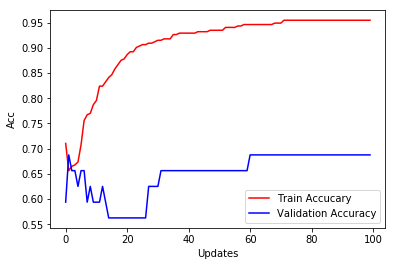

In [31]:
model.train()

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

for epoch in range(num_epochs):
    get_slice = lambda i, size: range(i * size, (i + 1) * size)
    optimizer.zero_grad()
    
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    model.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train_t.numpy()[slce]))
        output = model(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train_binary[slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)
    
    model.eval()
    ### Evaluate training - prediction accuracy on training data
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train_t.numpy()[slce]))

        output = model(x_batch)
        preds = torch.max(output, 1)[1] # returns index of max value in output vector

        train_targs += list(targets_train_binary[slce])
        train_preds += list(preds.data.numpy())
        
    ### Evaluate validation - prediction accuracy on validation data
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid_t.numpy()[slce]))

        output = model(x_batch)
        preds = torch.max(output, 1)[1]
        
        val_targs += list(targets_valid_binary[slce])
        val_preds += list(preds.data.numpy())
        
    #print("train_targs:", train_targs) # debugging
    #print() # debugging
    #print("train_preds", train_preds) # debugging
    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)

    train_acc.append(train_acc_cur) # for plot
    valid_acc.append(valid_acc_cur) # for plot
    
    if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
    #break # debugging
            
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()

In [32]:
print("after", num_epochs, "epochs with batchsize", batch_size, "and learning rate", learningrate)
print("final training accuracy:", train_acc[-1])
print("final validation accuracy:", valid_acc[-1])

after 100 epochs with batchsize 16 and learning rate 0.001
final training accuracy: 0.9545454545454546
final validation accuracy: 0.6875


We see here that the final validation accuracy is **68.7%**, which is almost exactly the same performance we get with the base model implemented with the NSL library and on the same politician dataset.